In [499]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
import os
import joblib

from collections import defaultdict

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, \
                            classification_report, precision_score, \
                            recall_score, roc_curve, precision_recall_curve, \
                            average_precision_score, recall_score, make_scorer, \
                            classification_report, average_precision_score, confusion_matrix
                
from sklearn.preprocessing import LabelEncoder, binarize
                
from sklearn.cross_validation import train_test_split, cross_val_predict

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, GridSearchCV, \
                                    cross_validate

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

pd.set_option('display.max_columns', None)

%matplotlib inline
pd.options.display.max_columns = 1000

In [500]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', UserWarning)

In [501]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [502]:
def feature_impotance(model, X_train, count_top_features = 20):
    imp=model.feature_importances_
    names=X_train.columns
    imp, names=map(list, zip(*sorted(zip(imp, names))[::-1][:count_top_features]))
    
    fig, ax = plt.subplots(figsize=(7,9))
    #ax = plt.axes()
    sns.barplot(x=imp, y=names, palette=sns.color_palette('YlGn', 2), ax=ax)
    ax.set_title('Top ' + str(count_top_features) + ' important features')
    plt.show()

def predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print('AUC: %.5f, Precision: %.5f, Recall: %.5f, F1: %.5f \n' % (roc_auc_score(y_test, y_pred_proba), \
                                    precision_score(y_test, y_pred), recall_score(y_test, y_pred), 
                                                                     f1_score(y_test, y_pred)))
    print('Average precision: %.5f \n' % average_precision_score(y_test, y_pred_proba))
    print(classification_report(y_test, y_pred, digits=5))
    confusion_matrix_heatmap(y_test, y_pred)
    
def confusion_matrix_heatmap(y_test, y_pred):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def eval_model_with_early_stopping(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train,
             eval_metric = 'auc',
             eval_set = [(X_train, y_train),(X_test, y_test)],
             early_stopping_rounds = 15, #сколько раундов не было улучшения на тесте
             verbose = 10)

    print('Test set')
    y_test_pred_model = model.predict(X_test)
    print(classification_report(y_test, y_test_pred_model, digits=5))
    auc = roc_auc_score(y_test, y_test_pred_model)
    print('AUC %.5f' % auc)
    confusion_matrix_heatmap(y_test, y_test_pred_model)

    return model, auc

In [503]:
df = pd.read_pickle('pkl_store/total_dataset_unencoded.pkl')

In [504]:
top_corr_features = pd.read_pickle('pkl_store/top_corr_features.pkl')

In [505]:
top_corr_features

['product',
 'product_group',
 'days_cr_q_end',
 'gosb',
 'tb',
 'days_between',
 'priority_client',
 'days_between_km_dealdiff',
 'sum_sold_total_cumulate_km_shift_3',
 'sum_sold_cumulate_agg_km_shift_1',
 'sum_sold_total_cumulate_km_shift_2',
 'sum_refused_tota_cumulate_km_shift_2',
 'sum_sold_total_cumulate_agg_km_shift_3',
 'sum_sold_total',
 'sum_refused_tota_cumulate',
 'sum_refused_tota_cumulate_km_shift_3',
 'corporate_cards',
 'acquiring_torg',
 'sum_sold_cumulate_agg_km_shift_2',
 'sum_sold_total_km_shift_3',
 'sum_sold_total_cumulate_agg_km_shift_1',
 'sum_sold_total_cumulate',
 'sum_sold_total_km_shift_2',
 'sum_sold_cumulate_agg_km_shift_3',
 'sum_sold_total_cumulate_agg_km_shift_2',
 'sum_sold_cumulate',
 'sum_sold_agg_km_shift_1',
 'sum_sold_cumulate_km_shift_3',
 'sum_sold_cumulate_km_shift_2',
 'sum_sold',
 'sum_sold_cumulate_company_shift_1',
 'sum_sold_km_shift_2',
 'acquiring_mobile_ratio',
 'valuta_control_ratio',
 'veksel_ratio',
 'inkass_ratio_share_prod_shift_3'

In [506]:
balance = pd.concat([df.groupby('product_group')['is_sold'].sum(), 
                     df.groupby('product_group')['is_sold'].count()], axis=1)
balance.columns = ['Sum of sold', 'Count']
balance['balance'] = balance['Sum of sold'] / balance['Count']
balance = balance.sort_values('balance', ascending=False)

In [507]:
product_groups_without_balance = list(balance[(balance['balance'] == 1) | (balance['balance'] == 0)].index)

In [508]:
df = df[~df['product_group'].isin(product_groups_without_balance)]

In [509]:
target_column = 'is_sold'
#drop_columns = ['ckp']
#X, y = df.drop(target_column, axis = 1).drop(drop_columns, 1), df[target_column]
X, y = df.drop(target_column, axis = 1), df[target_column]

In [510]:
X=X[top_corr_features]

In [511]:
X.shape

(415784, 158)

## Add new feature = log(sum of zeros by rows)

In [512]:
temp=np.log(len(X.columns)-X.astype(bool).fillna(0).sum(axis=1)+1)

In [513]:
temp.name='sum_of_zero'

In [514]:
temp.index=X.index

In [515]:
temp.head()

0    2.639057
1    1.386294
2    2.890372
3    2.639057
4    2.197225
Name: sum_of_zero, dtype: float64

In [516]:
X=X.join(temp)

In [517]:
X.shape

(415784, 159)

In [518]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.35, random_state=42)

## Label Encoding

In [519]:
from label_encoder import SoftLabelEncoder

In [520]:
label_encoders = {}
for col in X_train.dtypes[X_train.dtypes == 'O'].index:
    le = SoftLabelEncoder()
    X_train[col] = le.fit_transform(X_train.loc[:,col].fillna('NaN'))
    label_encoders[col] = le

/opt/cloudera/parcels/PYENV.ZNO41714840/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [521]:
joblib.dump(label_encoders, get_path('pkl_store', 'label_encoders.pkl'))

['pkl_store/label_encoders.pkl']

In [522]:
for col in X_test.dtypes[X_test.dtypes == 'O'].index:
    X_test[col] = le.transform(X_test.loc[:,col].fillna('NaN'))

New labels:  Прием по объявлению на взнос, Банковская гарантия, 2216/Бизнес-авто, Предзаявка в Сбербанк Лизинг, 1948/Экспресс-ипотека, ДС Школа, Премиальная Бизнес-карта, 2216/Бизнес-проект, Экспресс-онлайн (ИП Заемщик), Документарные операции, Прием наличных денежных средств на счет через УС, 2216/Бизнес-овердрафт, 1948/Экспресс-актив, Гарантия - обязательства по договору (Унифицированный), Эквайринг, Кредитование, Консалтинг по ВЭД и ВК, 2216/Бизнес-контракт, Лизинг Фабрика, Бухгалтерия для ИП, ПУ Актив, Прием платежей физ. лиц, СМС-информирование по расчетному счету, Инвестиционное кредитование (кроме строит-ва) (Структурированный), Страхование НС, Контрактное кредитование ЮЛ и ИП, ПУ Безналичный, Пакет услуг Хорошая выручка, 2216/Бизнес-недвижимость, ДМС. Сбереги здоровье, Защита сотрудников, Стабильный бизнес, Сервис проверки контрагентов, 2216/Бизнес-доверие, Валютный контроль, Системы ДБО, отличные от СББОЛ/СББ, ПУ Оптима+, ПУ Оптима, 1948/Доверие, ПУ Большие возможности, Депози

/opt/cloudera/parcels/PYENV.ZNO41714840/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


New labels:  Саратовское ГОСБ №8622, Пермское ГОСБ №6984, Центральный аппарат, Свердловское ГОСБ №7003, Псковское ГОСБ №8630, Мордовское ГОСБ №8589, Калужское ГОСБ №8608, Автозаводское ГОСБ №1039, Пензенское ГОСБ №8624, Ростовское ГОСБ №5221, Липецкое ГОСБ №8593, Северо-Восточное ГОСБ №8645, Оренбургское ГОСБ №8623, Калининградское ГОСБ №8626, Костромское ГОСБ №8640, ГО по Воронежской области, Камчатское ГОСБ №8556, Красноярское ГОСБ №8646, Дагестанское ОСБ №8590, Чеченское ОСБ №8643, Курганское ГОСБ №8599, Вологодское ГОСБ №8638, Тамбовское ГОСБ №8594, Ульяновское ГОСБ №8588, Сургутское ОСБ №5940, Тверское ГОСБ №8607, Ингушское ОСБ №8633, Калмыцкое ОСБ №8579, Новоуренгойское ОСБ №8369, Банк Татарстан ГОСБ №8610, Белгородское ГОСБ №8592, ГО по г. Санкт-Петербургу, Архангельское ГОСБ №8637, Абаканское ГОСБ №8602, Мурманское ГОСБ №8627, Северо-Осетинское ОСБ №8632, Иркутское ГОСБ №8586, Северное ГОСБ №1026, Приморское ГОСБ №8635, Марий Эл ГОСБ №8614, Владимирское ГОСБ №8611, Хабаровское 

In [523]:
mean_col_tr, std_col_tr   = X_train[top_corr_features].mean(), X_train[top_corr_features].std()
mean_col_tst, std_col_tst = X_test[top_corr_features].mean(), X_test[top_corr_features].std()

In [524]:
from joblib import Parallel, delayed

In [525]:
def cross_corr(col0, col1, mean_col, std_col, X):
    if col1!=col0:     
        corr10= (X[col0].fillna(mean_col[col0]) - mean_col[col0])* \
                (X[col1].fillna(mean_col[col1]) - mean_col[col1])/ \
                                            (std_col[col0]*std_col[col1])
        corr10.name='corr_'+col0+'_by_'+col1
        corr10.index=X.index
        X=X.join(corr10)
    return X

In [526]:
for col in top_corr_features[:10]:
    X_train=cross_corr(top_corr_features[0], col, mean_col_tr, std_col_tr, X_train)

In [527]:
for col in top_corr_features[:10]:
    X_test=cross_corr(top_corr_features[0], col, mean_col_tst, std_col_tst, X_test)

In [528]:
#out=Parallel(n_jobs=10) ( delayed(cross_corr)(top_corr_features[0], col, mean_col, std_col, X) for col in top_corr_features[:20] )

## Polynomial Features

from sklearn.preprocessing import PolynomialFeatures
import random

randcols=random.sample(top_corr_features,5)

pf = PolynomialFeatures(3,interaction_only=True)

## fit/transform train dataset

pf_df=pd.DataFrame(pf.fit_transform(X_test[randcols].fillna(X_test[randcols].mean())), 
                   columns=pf.get_feature_names(randcols), \
                   index=X_test.index)

pf_df.drop(["1"], axis=1, inplace=True)
pf_df.drop(randcols, axis=1, inplace=True)

pf_df.head()

X_test=X_test.join(pf_df)

X_test.shape

## transform test dataset

pf_df=pd.DataFrame(pf.transform(X_train[randcols].fillna(X_train[randcols].mean())), 
                   columns=pf.get_feature_names(randcols), \
                   index=X_train.index)

pf_df.drop(["1"], axis=1, inplace=True)
pf_df.drop(randcols, axis=1, inplace=True)

X_train=X_train.join(pf_df)

X_train.shape

## PCA

from sklearn.decomposition import PCA
from sklearn.manifold      import TSNE

n_dim=25

pca = PCA(n_components=n_dim)

X_components = pd.DataFrame(pca.fit_transform(X_train.fillna(X_train.mean())), columns=['pca_%.d' % i for i in range(n_dim)])
X_components.index = X_train.index
X_train = pd.concat([X_train, X_components], axis=1)

X_train.head()

X_components = pd.DataFrame(pca.transform(X_test.fillna(X_test.mean())), columns=['pca_%.d' % i for i in range(n_dim)])
X_components.index = X_test.index
X_test = pd.concat([X_test, X_components], axis=1)

## Fit model

## LightGBM

In [529]:
from lightgbm import LGBMClassifier, plot_metric, plot_importance

In [530]:
le=joblib.load(get_path('pkl_store', 'label_encoders.pkl'))
cat_features=list(set(le.keys()))
cat_features

['product_group', 'priority_client', 'gosb', 'segment_client', 'tb', 'product']

In [531]:
gbm = LGBMClassifier(n_estimators=15000, num_leaves=150, max_bin=100, bagging_fraction=0.8, bagging_freq=10, n_jobs=60, 
                     feature_fraction=0.5, lambda_l1=0, lambda_l2=1, min_child_weight=1e-05,
                     min_data_in_leaf=100, random_state=42)

In [532]:
%%time
gbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=15,
        eval_metric=['auc', 'logloss'], categorical_feature=cat_features, verbose=True)

[1]	training's auc: 0.848724	valid_1's auc: 0.616187
Training until validation scores don't improve for 15 rounds.
[2]	training's auc: 0.853977	valid_1's auc: 0.672802
[3]	training's auc: 0.856816	valid_1's auc: 0.663177
[4]	training's auc: 0.861167	valid_1's auc: 0.685306
[5]	training's auc: 0.862948	valid_1's auc: 0.655025
[6]	training's auc: 0.865246	valid_1's auc: 0.638326
[7]	training's auc: 0.866491	valid_1's auc: 0.641869
[8]	training's auc: 0.867277	valid_1's auc: 0.658793
[9]	training's auc: 0.868189	valid_1's auc: 0.644982
[10]	training's auc: 0.869001	valid_1's auc: 0.648645
[11]	training's auc: 0.870648	valid_1's auc: 0.655103
[12]	training's auc: 0.871419	valid_1's auc: 0.651041
[13]	training's auc: 0.872114	valid_1's auc: 0.65089
[14]	training's auc: 0.872594	valid_1's auc: 0.651066
[15]	training's auc: 0.873208	valid_1's auc: 0.651658
[16]	training's auc: 0.873931	valid_1's auc: 0.651263
[17]	training's auc: 0.874823	valid_1's auc: 0.651664
[18]	training's auc: 0.875439	

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting_type='gbdt',
        colsample_bytree=1.0, feature_fraction=0.5, lambda_l1=0,
        lambda_l2=1, learning_rate=0.1, max_bin=100, max_depth=-1,
        min_child_samples=10, min_child_weight=1e-05, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=15000, n_jobs=60, num_leaves=150,
        objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

AUC: 0.68531, Precision: 0.87319, Recall: 0.37682, F1: 0.52645 

Average precision: 0.85190 

             precision    recall  f1-score   support

          0    0.32129   0.84353   0.46534     37707
          1    0.87319   0.37682   0.52645    107818

avg / total    0.73019   0.49775   0.51062    145525



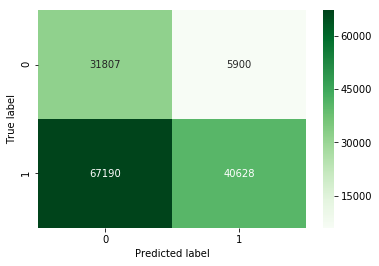

In [533]:
predict(gbm, X_test, y_test)

## XGboost

In [534]:
params = {
     'base_score': 0.5,
     'booster': 'gbtree',
     'colsample_bylevel': 1,
     'colsample_bytree': 0.6,
     'gamma': 5,
     'learning_rate': 0.1,
     'max_delta_step': 0,
     'max_depth': 10,
     'min_child_weight': 10,
     'missing': None,
     'n_estimators': 15000,
     'n_jobs': 60,
     'nthread': None,
     'objective': 'binary:logistic',
     'random_state': 0,
     'reg_alpha': 0,
     'reg_lambda': 1,
     'scale_pos_weight': 1,
     'seed': 42,
     'silent': True,
     'subsample': 1.0
}
xgb = XGBClassifier(**params)

In [535]:
%%time
xgb.fit(X_train, y_train,
             eval_metric = 'auc',
             eval_set = [(X_train, y_train),(X_test, y_test)],
             early_stopping_rounds = 15,
             verbose = 10)

[0]	validation_0-auc:0.857355	validation_1-auc:0.575206
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 15 rounds.
[10]	validation_0-auc:0.878729	validation_1-auc:0.691755
[20]	validation_0-auc:0.887045	validation_1-auc:0.709487
[30]	validation_0-auc:0.894125	validation_1-auc:0.715923
[40]	validation_0-auc:0.900551	validation_1-auc:0.718293
[50]	validation_0-auc:0.906095	validation_1-auc:0.723708
[60]	validation_0-auc:0.909353	validation_1-auc:0.724842
[70]	validation_0-auc:0.911868	validation_1-auc:0.722888
Stopping. Best iteration:
[63]	validation_0-auc:0.910056	validation_1-auc:0.726572

CPU times: user 13min 29s, sys: 11.1 s, total: 13min 40s
Wall time: 19.4 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=5, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=10, missing=None, n_estimators=15000,
       n_jobs=60, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1.0)

AUC: 0.72448, Precision: 0.77804, Recall: 0.90920, F1: 0.83852 

Average precision: 0.88459 

             precision    recall  f1-score   support

          0    0.49875   0.25833   0.34037     37707
          1    0.77804   0.90920   0.83852    107818

avg / total    0.70567   0.74055   0.70944    145525



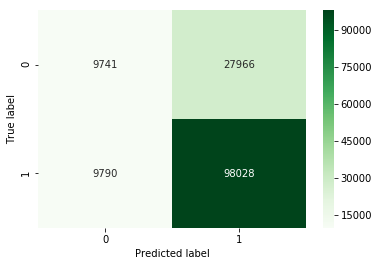

In [536]:
predict(xgb, X_test, y_test)

## Verify model on selected group of Products

In [494]:
list(le['product_group'].get_keys())

['КОНВЕРСИОННЫЕ ОПЕРАЦИИ',
 'ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ',
 'ФАКТОРИНГ',
 'ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ',
 'СТРАХОВАНИЕ',
 'БАНКОВСКАЯ ГАРАНТИЯ',
 'ПАКЕТЫ УСЛУГ',
 'ТЕХНИЧЕСКИЕ ПРОДУКТЫ',
 'ВНЕШНИЙ МАЛЫЙ СМАРТ',
 'КРЕДИТОВАНИЕ',
 'ВНЕШНИЙ МИКРО СМАРТ',
 'ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ',
 'ДЕЛОВАЯ СРЕДА',
 'ИНКАССАЦИЯ',
 'ПРИЕМ ПЛАТЕЖЕЙ ФИЗ. ЛИЦ',
 'РКО',
 'ИНФОРМАЦИОННЫЕ УСЛУГИ',
 'ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ',
 'ЭКВАЙРИНГ',
 'ЭВОТОР',
 'КРЕДИТНАЯ БИЗНЕС-КАРТА',
 'БИЗНЕС-КАРТА',
 'ДОКУМЕНТАРНЫЕ ОПЕРАЦИИ',
 'CASH MANAGEMENT',
 'ВАЛЮТНЫЙ КОНТРОЛЬ',
 'ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ',
 'ПРЕМИАЛЬНАЯ БИЗНЕС-КАРТА',
 'ЗАРПЛАТНЫЕ ПРОЕКТЫ']

In [495]:
df_trn=pd.concat([X_train,y_train], axis=1)
df_tst=pd.concat([X_test, y_test], axis=1)

In [496]:
df=pd.concat([df_trn,df_tst],axis=0).reset_index().drop(['index'],axis=1)

In [497]:
df.head()

,product,product_group,days_cr_q_end,gosb,tb,days_between,priority_client,days_between_km_dealdiff,sum_sold_total_cumulate_km_shift_3,sum_sold_cumulate_agg_km_shift_1,sum_sold_total_cumulate_km_shift_2,sum_refused_tota_cumulate_km_shift_2,sum_sold_total_cumulate_agg_km_shift_3,sum_sold_total,sum_refused_tota_cumulate,sum_refused_tota_cumulate_km_shift_3,corporate_cards,acquiring_torg,sum_sold_cumulate_agg_km_shift_2,sum_sold_total_km_shift_3,sum_sold_total_cumulate_agg_km_shift_1,sum_sold_total_cumulate,sum_sold_total_km_shift_2,sum_sold_cumulate_agg_km_shift_3,sum_sold_total_cumulate_agg_km_shift_2,sum_sold_cumulate,sum_sold_agg_km_shift_1,sum_sold_cumulate_km_shift_3,sum_sold_cumulate_km_shift_2,sum_sold,sum_sold_cumulate_company_shift_1,sum_sold_km_shift_2,acquiring_mobile_ratio,valuta_control_ratio,veksel_ratio,inkass_ratio_share_prod_shift_3,valuta_control_ratio_share_prod_shift_2,deposit_ratio,konversion_ratio,inkass_ratio_share_prod_shift_2,inkass_ratio,obsluzh_rts_val_ratio,deposit_ratio_share_prod_shift_2,acquiring_mobile_ratio_share_prod_shift_2,acquiring_mobile_ratio_share_prod_shift_3,konversion_ratio_share_prod_shift_2,valuta_control_ratio_share_prod_shift_3,obsluzh_rts_val_ratio_share_prod_shift_2,acquiring_torg_ratio,oborot_kredit_ratio,oborot_kredit_ratio_share_prod_shift_2,acquiring_torg_ratio_share_prod_shift_3,acquiring_torg_ratio_share_prod_shift_2,oborot_kredit_ratio_share_prod_shift_3,zarplat_projects_ratio,deposit_ratio_share_prod_shift_3,spec_acc_ratio,spec_acc_ratio_share_prod_shift_3,obsluzh_rts_val_ratio_share_prod_shift_3,konversion_ratio_share_prod_shift_3,spec_acc_ratio_share_prod_shift_2,overdraft_kredit_ratio,products_lizing_ratio,zarplat_projects_ratio_share_prod_shift_2,bank_straxovanie_imush_ratio,samoinkass,bank_straxovanie_imush_ratio_share_prod_shift_2,overdraft_kredit_ratio_share_prod_shift_2,bank_straxovanie_imush_ratio_share_prod_shift_3,ns_sait_ratio_share_prod_shift_2,samoinkass_share_prod_shift_3,products_lizing_ratio_share_prod_shift_2,products_lizing_ratio_share_prod_shift_3,overdraft_kredit_ratio_share_prod_shift_3,obsluzh_rts_rur,zarplat_projects_ratio_share_prod_shift_3,veksel_ratio_share_prod_shift_3,ns_sait_ratio,veksel_ratio_share_prod_shift_2,obsluzh_rts_rur_share_prod_shift_3,ns_sait_ratio_share_prod_shift_3,corporate_cards_share_prod_shift_2,samoinkass_ratio_share_prod_shift_2,samoinkass_ratio,samoinkass_ratio_share_prod_shift_3,einvoicing_ratio,einvoicing_ratio_share_prod_shift_3,einvoicing_ratio_share_prod_shift_2,oborot_kredit_share_prod_shift_3,oborot_kredit,oborot_kredit_share_prod_shift_2,zarplat_projects_share_prod_shift_3,acquiring_torg_share_prod_shift_3,acquiring_torg_share_prod_shift_2,zarplat_projects,sum_sold_total_agg_km_shift_3,sum_refused_tota_cumulate_agg_km_shift_1,sum_refused_tota_cumulate_agg_km_shift_3,sum_refused_total_km_shift_2,sum_refused_tota_cumulate_agg_km_shift_2,sum_refused_total_agg_km_shift_1,sum_sold_total_agg_km_shift_2,sum_sold_total_agg_km_shift_1,sum_refused_total_agg_km_shift_2,corporate_cards_ratio,corporate_cards_ratio_share_prod_shift_3,corporate_cards_ratio_share_prod_shift_2,dbo_ratio_share_prod_shift_3,dbo_ratio,obsluzh_rts_rur_ratio_share_prod_shift_3,obsluzh_rts_rur_ratio,obsluzh_rts_rur_ratio_share_prod_shift_2,dbo_ratio_share_prod_shift_2,sum_sold_cumulate_company_shift_2,bank_straxovanie_imush,bank_straxovanie_imush_share_prod_shift_3,bank_straxovanie_imush_share_prod_shift_2,garantee_kontract_ratio,garantee_kontract_ratio_share_prod_shift_2,garantee_kontract_ratio_share_prod_shift_3,sum_refused_total,bank_straxovanie_lich_ratio,bank_straxovanie_lich_ratio_share_prod_shift_2,bank_straxovanie_lich_ratio_share_prod_shift_3,invest_kredit_ratio,invest_kredit_ratio_share_prod_shift_2,invest_kredit_ratio_share_prod_shift_3,is_previous_sold_km_dealdiff,sum_refused_cumulate_agg_km_shift_2,sum_refused_cumulate_agg_km_shift_3,sum_refused_cumulate_agg_km_shift_1,cash_management_ratio,cash_management_ratio_share_prod_shift_3,cash_manage

Verify on product:  ЭКВАЙРИНГ
Training until validation scores don't improve for 15 rounds.
[10]	training's auc: 0.86065	valid_1's auc: 0.853356
[20]	training's auc: 0.86744	valid_1's auc: 0.858052
[30]	training's auc: 0.874519	valid_1's auc: 0.862424
[40]	training's auc: 0.880614	valid_1's auc: 0.865704
[50]	training's auc: 0.886389	valid_1's auc: 0.868556
[60]	training's auc: 0.891291	valid_1's auc: 0.870294
[70]	training's auc: 0.895605	valid_1's auc: 0.871572
[80]	training's auc: 0.899411	valid_1's auc: 0.872446
[90]	training's auc: 0.902748	valid_1's auc: 0.873307
[100]	training's auc: 0.905928	valid_1's auc: 0.873879
[110]	training's auc: 0.908878	valid_1's auc: 0.874417
[120]	training's auc: 0.911854	valid_1's auc: 0.874968
[130]	training's auc: 0.914469	valid_1's auc: 0.875358
[140]	training's auc: 0.917033	valid_1's auc: 0.87557
[150]	training's auc: 0.91959	valid_1's auc: 0.875984
[160]	training's auc: 0.921894	valid_1's auc: 0.876414
[170]	training's auc: 0.924336	valid_1's 

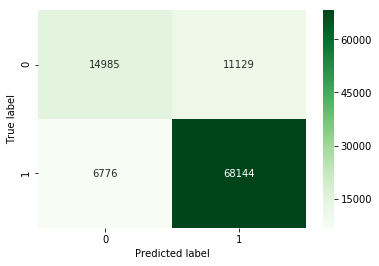

             precision    recall  f1-score   support

          0    0.41752   0.39321   0.40500      3624
          1    0.73297   0.75224   0.74248      8024

avg / total    0.63482   0.64054   0.63748     11648

AUC 0.57273


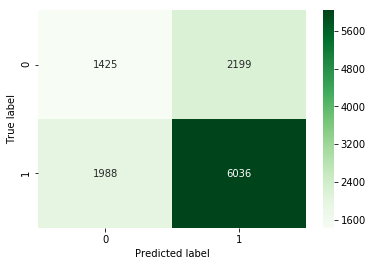

--------------------------------------------------------------------------------
Verify on product:  ПАКЕТЫ УСЛУГ
Training until validation scores don't improve for 15 rounds.
[10]	training's auc: 0.855101	valid_1's auc: 0.849574
[20]	training's auc: 0.863073	valid_1's auc: 0.855236
[30]	training's auc: 0.869276	valid_1's auc: 0.858856
[40]	training's auc: 0.875927	valid_1's auc: 0.862246
[50]	training's auc: 0.881636	valid_1's auc: 0.864671
[60]	training's auc: 0.886764	valid_1's auc: 0.866388
[70]	training's auc: 0.891148	valid_1's auc: 0.867603
[80]	training's auc: 0.895225	valid_1's auc: 0.868719
[90]	training's auc: 0.898983	valid_1's auc: 0.86951
[100]	training's auc: 0.902337	valid_1's auc: 0.870248
[110]	training's auc: 0.90565	valid_1's auc: 0.870857
[120]	training's auc: 0.908523	valid_1's auc: 0.871421
[130]	training's auc: 0.911385	valid_1's auc: 0.871678
[140]	training's auc: 0.914134	valid_1's auc: 0.871913
[150]	training's auc: 0.916655	valid_1's auc: 0.872159
[160]	trai

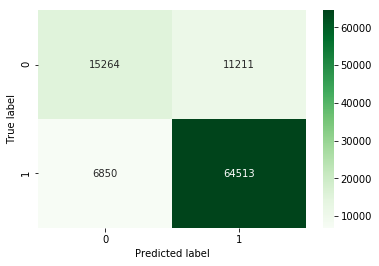

             precision    recall  f1-score   support

          0    0.16223   0.67874   0.26187      2182
          1    0.95420   0.65632   0.77771     22253

avg / total    0.88348   0.65832   0.73165     24435

AUC 0.66753


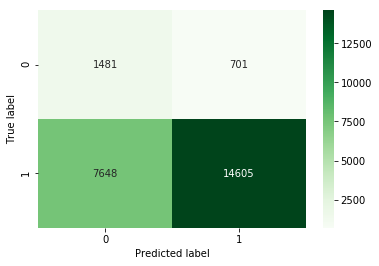

--------------------------------------------------------------------------------
Verify on product:  РКО
Training until validation scores don't improve for 15 rounds.
[10]	training's auc: 0.844715	valid_1's auc: 0.841369
[20]	training's auc: 0.853004	valid_1's auc: 0.84725
[30]	training's auc: 0.860508	valid_1's auc: 0.85166
[40]	training's auc: 0.867319	valid_1's auc: 0.854979
[50]	training's auc: 0.873501	valid_1's auc: 0.857516
[60]	training's auc: 0.878792	valid_1's auc: 0.859191
[70]	training's auc: 0.883609	valid_1's auc: 0.860333
[80]	training's auc: 0.887739	valid_1's auc: 0.861331
[90]	training's auc: 0.891812	valid_1's auc: 0.862062
[100]	training's auc: 0.895245	valid_1's auc: 0.862584
[110]	training's auc: 0.898869	valid_1's auc: 0.863211
[120]	training's auc: 0.902074	valid_1's auc: 0.863507
[130]	training's auc: 0.905245	valid_1's auc: 0.863871
[140]	training's auc: 0.908128	valid_1's auc: 0.864212
[150]	training's auc: 0.910909	valid_1's auc: 0.864537
[160]	training's au

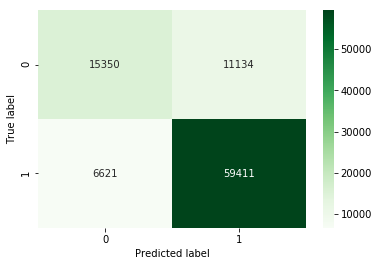

             precision    recall  f1-score   support

          0    0.16103   0.06431   0.09191      2146
          1    0.95524   0.98350   0.96916     43574

avg / total    0.91796   0.94035   0.92799     45720

AUC 0.52390


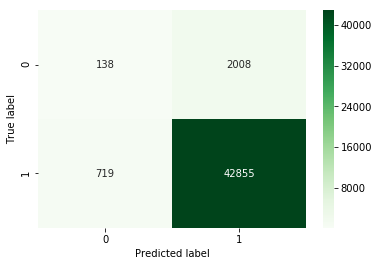

--------------------------------------------------------------------------------


In [498]:
# депозиты, пакеты услуг, Лизинг
products = { 'ПАКЕТЫ УСЛУГ': le['product_group'].get_dict()['ПАКЕТЫ УСЛУГ'], 
             'РКО':          le['product_group'].get_dict()['РКО'], 
             'ЭКВАЙРИНГ':    le['product_group'].get_dict()['ЭКВАЙРИНГ']}
for key, value in products.items():
    print('Verify on product: ', key)
    X_val, y_val = df[df['product_group'] == value].drop(target_column, axis = 1), df[df['product_group'] == value][target_column]
        
    X, y = df[df['product_group'] != value].drop(target_column, axis = 1), df[df['product_group'] != value][target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    model, auc = eval_model_with_early_stopping(gbm, X_train, y_train, X_test, y_test)
    
    y_val_pred = model.predict(X_val)
    print(classification_report(y_val, y_val_pred, digits=5))
    print('AUC %.5f' % roc_auc_score(y_val, y_val_pred))
    confusion_matrix_heatmap(y_val, y_val_pred)
    print('-' * 80)